In [39]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
from sklearn import preprocessing
import numpy as np
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
tf.random.set_seed(13)
pd.options.display.max_rows = 8


import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
#from tensorflow import set_random_seed
tf.random.set_seed(4)
#from util import csv_to_dataset, history_points

def plotxx(xx, yy, model, pn=-200):
    xt= xx[pn:]
    technical_indicators_t = np.array([[0]] * len(xt))

    yt = yy[pn:]
    xt.shape, technical_indicators_t.shape, yt.shape
    yh = model.predict([xt, technical_indicators_t])
    
    plt.plot(yt, marker='o', label="orginal")
    plt.plot(yh, marker='x', label="Predicted")

    plt.legend()

def plotxx1(xx, yy, model, pn=-200):
    xt= xx[pn:]

    yt = yy[pn:]
    xt.shape, technical_indicators_t.shape, yt.shape
    yh = model.predict(xx)
    
    plt.plot(yt, marker='o', label="orginal")
    plt.plot(yh, marker='x', label="Predicted")

    plt.legend()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
##SADA

csv_path="MSFT_daily.csv"
data = pd.read_csv(csv_path)
data = data.drop(0, axis=0)
data.columns="date open high low close volume".split()
col='open'
#data[f'{col}_diff1'] = data[col] - data[col].shift(1)
data.dropna(inplace=True)
data

scaler = preprocessing.StandardScaler()
datan  = scaler.fit_transform(data[data.columns[1:]])
scaler = preprocessing.MinMaxScaler()
datan  = scaler.fit_transform(data[data.columns[1:]])

datan.shape

(5032, 5)

In [4]:
from keras.preprocessing.sequence import TimeseriesGenerator
history_points = 50

tsParams = {'length': history_points, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1}
X = datan
y = datan[:,0]
y = y.reshape(-1,1)
nl = X.shape[0]
n = int(len(X) * .9)

trng    = TimeseriesGenerator(X[:n], y[:n], **tsParams )
valg    = TimeseriesGenerator(X[n:], y[n:], **tsParams )
technical_indicators = np.array([[0]] * len(trng))
n, len(trng),n, datan.shape, trng[0][0].shape

(4528, 4478, 4528, (5032, 5), (1, 50, 5))

In [5]:
xx= np.array([trng[i][0][0] for i in range(len(trng))])
technical_indicators = np.array([[0]] * len(xx))

yy = np.array([trng[i][1][0] for i in range(len(trng))])
xx.shape, technical_indicators.shape, yy.shape

((4478, 50, 5), (4478, 1), (4478, 1))

In [6]:
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
#model = Model(inputs=lstm_branch.input, outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')


Train on 4030 samples, validate on 448 samples
Epoch 1/2
4030/4030 [==============================] - 2s 461us/step - loss: 5.4892e-05 - val_loss: 1.5675e-05
Epoch 2/2
4030/4030 [==============================] - 2s 459us/step - loss: 5.9746e-05 - val_loss: 1.4231e-05


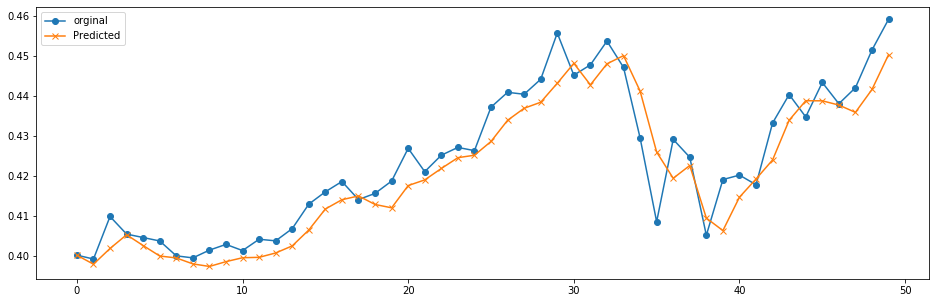

In [35]:
model.fit([xx[:n], technical_indicators[:n]], y=yy[:n], epochs=2, shuffle=True, validation_split=0.1)

# evaluation
'''
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)
''';
plotxx(xx,yy, model, -50)

In [ ]:
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)

output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
#model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
model.fit(xx[:n], y=yy[:n], epochs=4, shuffle=True, validation_split=0.1)


In [ ]:
model.fit(xx[:n], y=yy[:n], epochs=10, shuffle=True, validation_split=0.1)

In [ ]:
model.fit(trng, verbose=1, epochs=1, validation_data=None,steps_per_epoch=200,
                   validation_steps=50)

xt= xx[n:]

yt = yy[n:]
xt.shape, technical_indicators_t.shape, yt.shape
yh = model.predict(xt)
plt.plot(yt)
plt.plot(yh)

In [ ]:
yy.shape, xx.shape

In [25]:
from keras.layers import RepeatVector, TimeDistributed
model1=None      

#sensN = len(self.train_transformed[0].columns)  # number of sensors (eliminating the two time ones)
#outN = len(self.num_id_list) # number of output sensors; the non-categorical ones        

lookBack   = tsParams['length']
nFeatures  = xx.shape[2]  # Number of features 
lstm_OPDim = yy.shape[1]  # This is usually all sensors except categorical that to train LSTM on
lstm_IPDim = 256
drop       = 0.3
optimizer  = optimizers.Adam(lr=0.0005)
loss       = 'mse'
k_rrizer   = None
r_rrizer   = None

input_layer  = Input(shape=(lookBack, nFeatures), dtype='float32', name='input')
memory_layer = LSTM( lstm_IPDim, return_sequences=True, name="memory1")(input_layer)
memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=False, name="memory2")(memory_layer)
repeated = RepeatVector(lookBack)(memory_layer)
memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=True, name="first1out")(repeated)
memory_layer = LSTM (lstm_IPDim,  return_sequences=True, name="first2out")(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=lstm_OPDim, activation='linear'))( memory_layer)

#  Try spatial dropout?
dropout_input = Dropout(drop)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])

#memory_layer = LSTM (units=self.lstm_dim, return_sequences=False)(concat_layer)
memory_layer = LSTM (units=lstm_IPDim, 
                         kernel_regularizer = k_rrizer, 
                         recurrent_regularizer = r_rrizer, 
                         return_sequences=False)(concat_layer)
preds = Dense(units=lstm_OPDim, activation='linear')(memory_layer)

model1 = Model(input_layer, preds)
model1.compile(optimizer = optimizer, loss= loss)             

print(model1.summary())


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 5)        0                                            
__________________________________________________________________________________________________
memory1 (LSTM)                  (None, 50, 256)      268288      input[0][0]                      
__________________________________________________________________________________________________
memory2 (LSTM)                  (None, 128)          197120      memory1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 50, 128)      0           memory2[0][0]                    
____________________________________________________________________________________________

Epoch 1/1
200/200 [==============================] - 17s 86ms/step - loss: 4.8301e-04


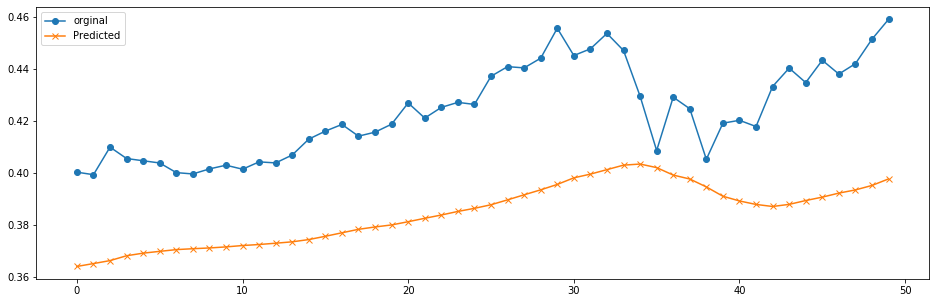

In [43]:
for i in range(1):
    model1.fit(trng, verbose=1, epochs=1, validation_data=None,steps_per_epoch=200,
                   validation_steps=50)

    plotxx1(xx,yy, model1, -50)


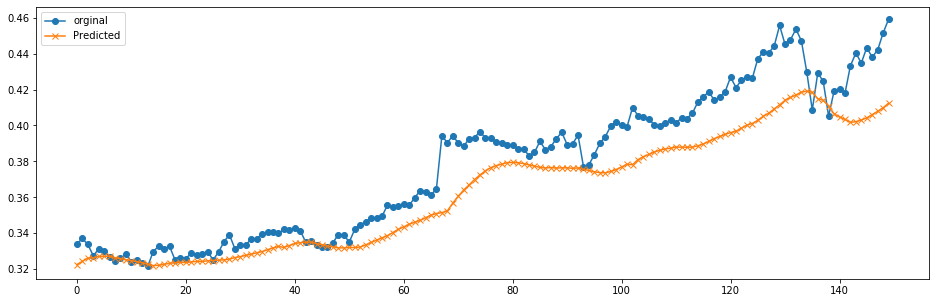

In [42]:
def plotxx1(xx, yy, model, pn=-200):
    xt = xx[pn:]
    yt = yy[pn:]
    yh = model.predict(xt)
    
    plt.plot(yt, marker='o', label="orginal")
    plt.plot(yh, marker='x', label="Predicted")

    plt.legend()

plotxx1(xx,yy, model1, -150)
